In [1]:
from ManuscriptAnalysis.Gentec_CCD_analysis.Gentec_linearity_Analysis import beam_characterization_df_GENTEC_horizontal
%matplotlib widget
import sys
import os
import matplotlib.pyplot as plt

# Path to the directory containing the script you want to import
# Replace with the actual absolute or relative path
path_to_other_project_directory = '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/Scripts/GlazCamera_PP_DataAnalysis'

# Add the directory to sys.path
# os.path.abspath ensures the path is absolute
if os.path.abspath(path_to_other_project_directory) not in sys.path:
    sys.path.append(os.path.abspath(path_to_other_project_directory))

import Glaz_PP_Series_analysis
from Glaz_PP_Series_analysis import GlazPPSeriesAnalysis

plt.close('all')
parent_dir_path = '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz Camera/20250524/EOS_spectral_dependence/AllRelevantData'
GlazPPSeriesAnalysis = GlazPPSeriesAnalysis(parent_dir_path, )

# GlazPPSeriesAnalysis.plot_all_spectrum_timetraces(keyword='SpectralDifference',
#                                                    bool_plot_normalized_time_trace=False)

fig_ffts, ax_ffts = GlazPPSeriesAnalysis.plot_all_ffts_together(pixel=310,
                                                                window_start=0,
                                                                window_end=4,
                                                                bool_organize_legend=True,
                                                                bool_save_fig=True,
                                                                plot_x_lim_min=0,
                                                                plot_x_lim_max=10)

data_df = GlazPPSeriesAnalysis.plot_all_timetraces_at_pixel_separately_returning_data(pixel=310,
                                                                                      number_of_pixels_for_average=5,
                                                                                      spectrum_type_keyword='SpectralDifference',
                                                                                      save_fig_bool=True)

fig_ffts


ModuleNotFoundError: No module named 'ManuscriptAnalysis.Gentec_CCD_analysis.Gentec_linearity_Analysis'

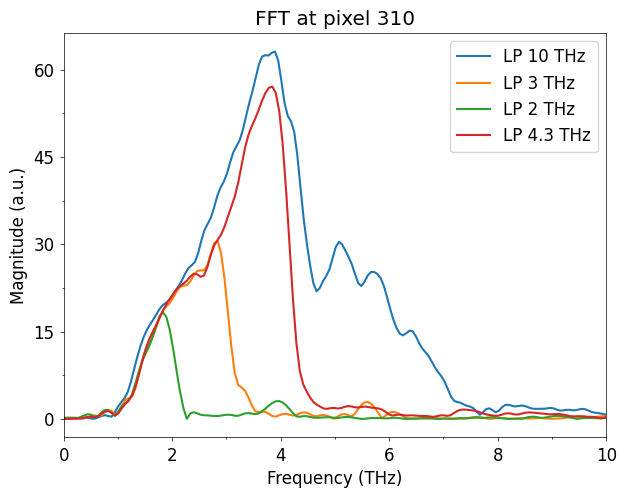

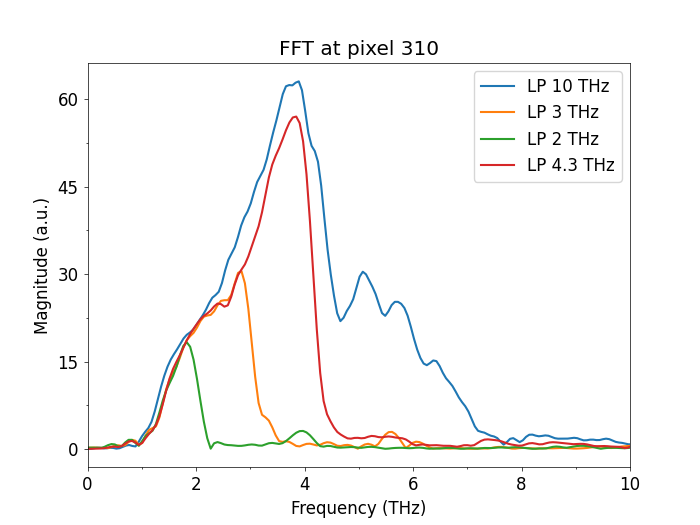

In [2]:
%matplotlib widget
# Ensure GlazPPSeriesAnalysis is still defined and in scope from the previous cell
fig_ffts, ax_ffts = GlazPPSeriesAnalysis.plot_all_ffts_together(pixel=310,
                                                                window_start=0,
                                                                window_end=4,
                                                                bool_organize_legend=True,
                                                                bool_save_fig=True,
                                                                # Or False if you don't want to save again
                                                                plot_x_lim_min=0,
                                                                plot_x_lim_max=10)
fig_ffts  # This will now display the interactive figure


--- Aligning Traces by First Peak (find_peaks method) ---
Found first peak for 'LP 10 THz' at t = 0.305 ps. Shifting time axis.
Found first peak for 'LP 3 THz' at t = 0.668 ps. Shifting time axis.
Found first peak for 'LP 2 THz' at t = 0.879 ps. Shifting time axis.
Found first peak for 'LP 4.3 THz' at t = 0.425 ps. Shifting time axis.
--- Alignment Complete ---
--- Starting Integration ---
Successfully integrated 'LP 10 THz' from t=-0.4 to t=3.5. Integral = 7119972.0795
Successfully integrated 'LP 3 THz' from t=-0.4 to t=3.5. Integral = 2134448.2023
Successfully integrated 'LP 2 THz' from t=-0.4 to t=3.5. Integral = 699080.0127
Successfully integrated 'LP 4.3 THz' from t=-0.4 to t=3.5. Integral = 5033167.1198
--- Integration Complete ---


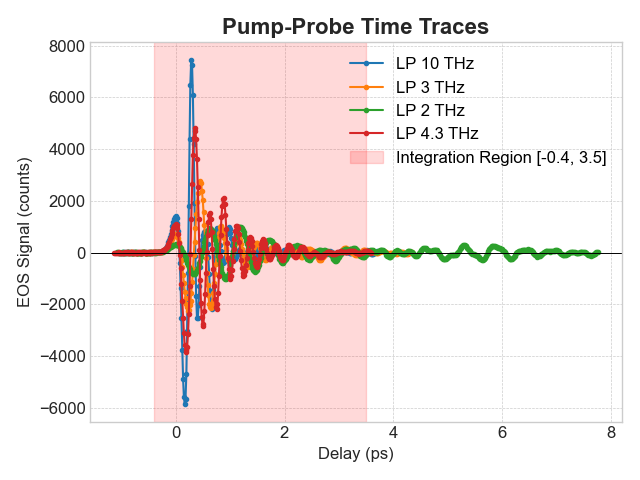

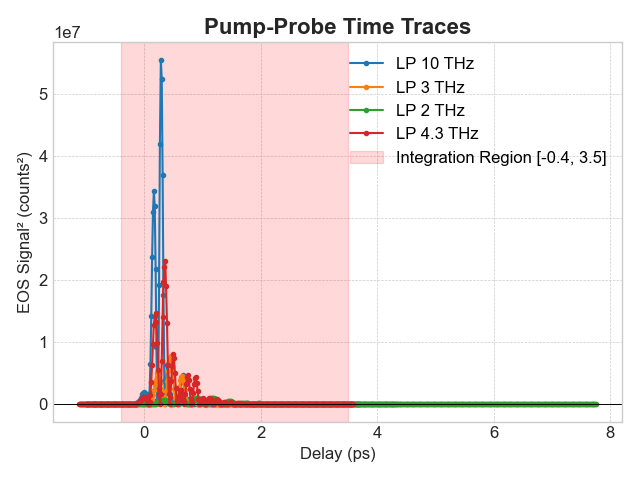

,Signal_Column,Integral_Value
0,LP 10 THz,7.119972e+06
1,LP 3 THz,2.134448e+06
2,LP 2 THz,6.990800e+05
3,LP 4.3 THz,5.033167e+06


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def align_traces_by_first_peak(data_df,
                               peak_height_threshold=0.1):
    """
    Aligns pump-probe traces by shifting their time axes to the first peak.

    This function uses scipy.signal.find_peaks to identify all local maxima
    in the absolute signal that are above a certain threshold. It then selects
    the *first* of these peaks that occurs after t=0 and shifts the time axis
    of the trace so this peak is at t=0.

    Args:
        data_df (pd.DataFrame): The input DataFrame with pump-probe data.
        peak_height_threshold (float): The minimum height for a peak to be
                                       detected. Helps to ignore noise.

    Returns:
        pd.DataFrame: A new DataFrame with the time-aligned traces.
    """
    print("--- Aligning Traces by First Peak (find_peaks method) ---")
    aligned_df = data_df.copy()
    signal_column_names = [col for col in data_df.columns if not col.startswith('delay_')]

    for signal_col_name in signal_column_names:
        delay_col_name = f"delay_{signal_col_name}"

        if delay_col_name not in data_df.columns:
            continue

        # Extract relevant data, dropping NaNs
        current_data = data_df[[delay_col_name, signal_col_name]].dropna()
        delays = current_data[delay_col_name].values
        pp_signal = current_data[signal_col_name].values

        # Find all peaks in the absolute signal above the height threshold
        peak_indices, _ = find_peaks(np.abs(pp_signal),
                                     height=peak_height_threshold)

        if peak_indices.size == 0:
            print(f"Warning: No peaks found for '{signal_col_name}' above height {peak_height_threshold}. Skipping alignment.")
            continue

        # Get the times of all detected peaks
        all_peak_times = delays[peak_indices]

        # Filter for peaks that occur after t=0
        peaks_after_zero = all_peak_times[all_peak_times > 0]

        if peaks_after_zero.size == 0:
            print(f"Warning: No peaks found after t=0 for '{signal_col_name}'. Skipping alignment for this trace.")
            continue

        # The first peak after t=0 is the one we want to align to
        time_of_first_peak = peaks_after_zero[0]

        print(f"Found first peak for '{signal_col_name}' at t = {time_of_first_peak:.3f} ps. Shifting time axis.")

        # Apply the time shift to the entire delay column for this trace
        aligned_df[delay_col_name] = aligned_df[delay_col_name] - time_of_first_peak

    print("--- Alignment Complete ---")
    return aligned_df


def integrate_pp_data(data_df,
                      time_min,
                      time_max):
    """
    Integrates pump-probe data columns within a specified time range.

    This function integrates the SQUARE of the signal (signal^2), which is
    proportional to the signal power/energy.

    Args:
        data_df (pd.DataFrame): DataFrame containing delay and pump-probe data.
                                Expected column naming: 'LP X THz' for data,
                                'delay_LP X THz' for corresponding delays.
        time_min (float): The minimum time for the integration window.
        time_max (float): The maximum time for the integration window.

    Returns:
        pd.DataFrame: A DataFrame with columns 'Signal_Column' and 'Integral_Value'.
                      Returns an empty DataFrame if no valid columns are found or
                      if an error occurs.
    """
    results = []
    print("--- Starting Integration ---")

    # Identify the base names of the signals by finding columns that do not start with 'delay_'
    signal_column_names = [col for col in data_df.columns if not col.startswith('delay_')]

    if not signal_column_names:
        print("Error: No potential signal columns found (i.e., columns not starting with 'delay_').")
        return pd.DataFrame(columns=['Signal_Column', 'Integral_Value'])

    for signal_col_name in signal_column_names:
        delay_col_name = f"delay_{signal_col_name}"

        if delay_col_name not in data_df.columns:
            print(f"Warning: Delay column '{delay_col_name}' not found for signal '{signal_col_name}'. Skipping.")
            continue

        # Drop NaNs for the current pair of columns to ensure clean processing.
        current_data = data_df[[delay_col_name, signal_col_name]].dropna()

        if current_data.empty:
            print(f"Warning: No valid data (after dropping NaNs) for signal '{signal_col_name}'. Skipping.")
            continue

        delays = current_data[delay_col_name].values
        pp_signal = current_data[signal_col_name].values

        # Filter data to lie within the specified time range
        integration_mask = (delays >= time_min) & (delays <= time_max)

        filtered_delays = delays[integration_mask]
        filtered_pp_signal = pp_signal[integration_mask]

        if len(filtered_delays) < 2:
            print(f"Warning: Not enough data points (<2) for integration in signal '{signal_col_name}' "
                  f"within the range [{time_min}, {time_max}]. Skipping.")
            continue

        # Ensure delays are sorted for the trapezoidal rule.
        sort_indices = np.argsort(filtered_delays)
        sorted_filtered_delays = filtered_delays[sort_indices]
        sorted_filtered_pp_signal = filtered_pp_signal[sort_indices]

        # Perform numerical integration of the square of the signal.
        integral_value = np.trapz(sorted_filtered_pp_signal ** 2,
                                  sorted_filtered_delays)

        results.append({'Signal_Column': signal_col_name, 'Integral_Value': integral_value})
        print(f"Successfully integrated '{signal_col_name}' from t={time_min} to t={time_max}. Integral = {integral_value:.4f}")

    if not results:
        print("--- Integration Finished: No integrations were performed. ---")
        return pd.DataFrame(columns=['Signal_Column', 'Integral_Value'])

    print("--- Integration Complete ---")
    return pd.DataFrame(results)


def plot_pp_data(data_df,
                 time_min=None,
                 time_max=None,
                 title="Pump-Probe Time Traces"):
    """
    Plots pump-probe time traces on top of each other for visual inspection.

    Args:
        data_df (pd.DataFrame): DataFrame with delay and pump-probe data columns.
        time_min (float, optional): Start of the integration range to highlight.
        time_max (float, optional): End of the integration range to highlight.
        title (str, optional): The title for the plot.

    Returns:
        tuple: A tuple containing the matplotlib figure and axes objects (fig, ax).
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots()
    plot_count = 0
    signal_column_names = [col for col in data_df.columns if not col.startswith('delay_')]

    if not signal_column_names:
        print("Error: No signal columns found to plot.")
        return None, None

    for signal_col_name in signal_column_names:
        delay_col_name = f"delay_{signal_col_name}"

        if delay_col_name not in data_df.columns:
            continue

        current_data = data_df[[delay_col_name, signal_col_name]].dropna()

        if not current_data.empty:
            ax.plot(current_data[delay_col_name],
                    current_data[signal_col_name],
                    label=signal_col_name,
                    marker='o',
                    markersize=3,
                    linestyle='-')
            plot_count += 1

    if plot_count == 0:
        print("Warning: No data was plotted. Check column names and data content.")
        return None, None

    if time_min is not None and time_max is not None:
        ax.axvspan(time_min,
                   time_max,
                   color='red',
                   alpha=0.15,
                   label=f'Integration Region [{time_min}, {time_max}]')

    ax.set_xlabel("Delay (ps)",
                  fontsize=12)
    ax.set_ylabel("EOS Signal (counts)",
                  fontsize=12)
    ax.set_title(title,
                 fontsize=16,
                 fontweight='bold')
    ax.legend()
    ax.grid(True,
            which='both',
            linestyle='--',
            linewidth=0.5)
    ax.axhline(0,
               color='black',
               linewidth=0.7)
    fig.tight_layout()
    plt.show()
    return fig, ax

def plot_pp_data_squared(data_df,
                 time_min=None,
                 time_max=None,
                 title="Pump-Probe Time Traces"):
    """
    Plots pump-probe time traces on top of each other for visual inspection.

    Args:
        data_df (pd.DataFrame): DataFrame with delay and pump-probe data columns.
        time_min (float, optional): Start of the integration range to highlight.
        time_max (float, optional): End of the integration range to highlight.
        title (str, optional): The title for the plot.

    Returns:
        tuple: A tuple containing the matplotlib figure and axes objects (fig, ax).
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots()
    plot_count = 0
    signal_column_names = [col for col in data_df.columns if not col.startswith('delay_')]

    if not signal_column_names:
        print("Error: No signal columns found to plot.")
        return None, None

    for signal_col_name in signal_column_names:
        delay_col_name = f"delay_{signal_col_name}"

        if delay_col_name not in data_df.columns:
            continue

        current_data = data_df[[delay_col_name, signal_col_name]].dropna()

        if not current_data.empty:
            ax.plot(current_data[delay_col_name],
                    current_data[signal_col_name]**2,
                    label=signal_col_name,
                    marker='o',
                    markersize=3,
                    linestyle='-')
            plot_count += 1

    if plot_count == 0:
        print("Warning: No data was plotted. Check column names and data content.")
        return None, None

    if time_min is not None and time_max is not None:
        ax.axvspan(time_min,
                   time_max,
                   color='red',
                   alpha=0.15,
                   label=f'Integration Region [{time_min}, {time_max}]')

    ax.set_xlabel("Delay (ps)",
                  fontsize=12)
    ax.set_ylabel("EOS Signal² (counts²)",
                  fontsize=12)
    ax.set_title(title,
                 fontsize=16,
                 fontweight='bold')
    ax.legend()
    ax.grid(True,
            which='both',
            linestyle='--',
            linewidth=0.5)
    ax.axhline(0,
               color='black',
               linewidth=0.7)
    fig.tight_layout()
    plt.show()
    return fig, ax



# Define your integration time limits
time_min_integrate = -.4  # example value
time_max_integrate = 3.5  # example value
aligned_data_df = align_traces_by_first_peak(data_df,
                                             peak_height_threshold=100)
integrated_results_df = integrate_pp_data(aligned_data_df,
                                          time_min_integrate,
                                          time_max_integrate)
fig_aligned_timetrace, ax_aligned_timetrace = plot_pp_data(aligned_data_df,
             time_min=time_min_integrate,
             time_max=time_max_integrate)
ax_aligned_timetrace.set_xlim(-.5, 4)
fig_aligned_timetrace.savefig('Integrated_timetrace.pdf')

fig_squared_timetrace, ax_squared_timetrace = plot_pp_data_squared(aligned_data_df,
             time_min=time_min_integrate,
             time_max=time_max_integrate)
ax_squared_timetrace.set_xlim(-.5, 4)
fig_squared_timetrace.savefig('Integrated_timetrace_squared.pdf')



In [12]:
integrated_results_df

,Signal_Column,Integral_Value
0,LP 10 THz,7.119972e+06
1,LP 3 THz,2.134448e+06
2,LP 2 THz,6.990800e+05
3,LP 4.3 THz,5.033167e+06


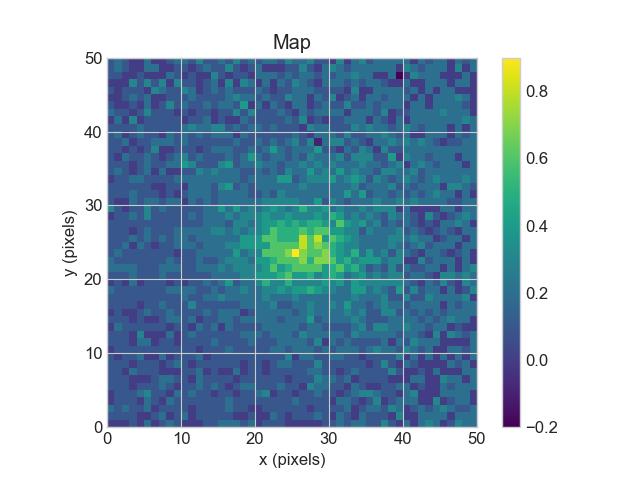

In [7]:
from BeamAnalysis import BeamAnalysis

%matplotlib widget
dir_path_HIKMICRO = '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz Camera/20250514/HIKMICRO_camera/SpectralSeries'
filename = 'LP 2 THz.csv'
x_center_HIKMICRO = 157
y_center_HIKMICRO = 98
width = 50
crop_x_range_HIKMICRO = (x_center_HIKMICRO - width / 2, x_center_HIKMICRO + width / 2)
crop_y_range_HIKMICRO = (y_center_HIKMICRO - width / 2, y_center_HIKMICRO + width / 2)
beam_analysis_HIKMICRO = BeamAnalysis(dir_path=dir_path_HIKMICRO,
                                      signal_filename=filename,
                                      camera_name='HIKMICRO',
                                      crop_range_x_pixels=crop_x_range_HIKMICRO,
                                      crop_range_y_pixels=crop_y_range_HIKMICRO)
fig_HIKMICRO, ax_HIKMICRO = beam_analysis_HIKMICRO.plot_map_in_pixels()


In [10]:
from SeriesAnalyzer_2 import SeriesAnalyzer_2
%matplotlib widget
HIKMICRO_path = '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz Camera/20250514/HIKMICRO_camera/SpectralSeries'
HIKMICRO_series_analyzer = SeriesAnalyzer_2(dir_path=HIKMICRO_path,
                                            camera_name='HIKMICRO',
                                            crop_range_x_pixels=crop_x_range_HIKMICRO,
                                            crop_range_y_pixels=crop_y_range_HIKMICRO,
                                            Y_ref_position_for_background_subtraction=2)
beam_characterization_df = HIKMICRO_series_analyzer.get_beam_characterization_df(save_data_plot_bool=True, )
HIKMICRO_series_analyzer.plot_all_map_analysis(save_data_plot_bool=True)

In [11]:
beam_characterization_df

,FWHM_x (pixels),FWHM_y (pixels),total_intensity,filenames,FWHM_x (um),FWHM_y (um)
0,11.120192,10.029612,7834.2,"LP 4,3 THz",144.562500,130.384961
1,10.229085,9.327674,10874.8,LP 10 THz,132.978105,121.259760
2,12.811071,10.051159,4787.8,LP 2 THz with NE10 only,166.543929,130.665067
3,9.366667,6.525000,176.2,LP 2 THz,121.766667,84.825000
4,13.425000,13.232500,619.8,LP 3 THz,174.525000,172.022500


In [14]:
integrated_results_df

,Signal_Column,Integral_Value
0,LP 10 THz,7.119972e+06
1,LP 3 THz,2.134448e+06
2,LP 2 THz,6.990800e+05
3,LP 4.3 THz,5.033167e+06
